# continuous bayes

By analogy, I hope to back into what the fuck i'm looking for.

We assume `m` is some parameter correlating with how good a player is. Assume higher values of `x` correspond to better players.

The pdf of `x` can be thought of as a straight line on the range `(0,1)`. For bad players, this will correspond to a lower (negative) value of `m`. For the best players, we'll have a positive slope, y-intercept of 0, culminating at 2. 

```
range (0,1)
bad player:  m = -2 | pdf(x) = 2 - 2x
good player: m = +2 | pdf(x) = 2x
```

Which can be extrapolated:

```
pdf(x|m) = m*(x-1/2) + 1
```

Let's assume the likelihood of m goes like:

```
pdf(m) = 1/4 * (1 - m/2)
```

Let's assume we have a random player. We should set some prior (let's start with uniform) but we want to run through trials (play games) and update that prior to attempt to determine what the probability of x is for this given player. Our observations will be values of `x`. So this player will, in theory, have some given value of `m`, but we're interested in finding out what his pdf of `x` is.

So the fundamental beauty is that we can begin to knowingly assemble a probability distribution for a player with a small amount of data.


After doing a bunch of math:

```
pdf(x) = 2/3 * (2-x)
```

and

```
pdf(m|x) = 3/8 * 1/(x-2) * ( m^2/2 * (x - 1/2) + m * (1-x) - 1 ) 
```

For the continuous case,

```
pdf(w|x) dx = p(x|w) * pdf(w)dw / p(x)
```

So we can begin with our prior as `pdf(x)`:

```
pdf(x|m) = pdf(m|x=0.75) pdf(x) / pdf(m)
```


In [238]:
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [316]:
x_range = (0,1)
m_range = (-2,2)

def pdf_x_m(x, m):
    return m * (x - 1.0/2) + 1.0

def pdf_m(m):
    return 1.0/4 * (1.0 - m/2)

def pdf_m_x(m, x):
    return 3.0/8 * 1.0/(x-2.0) * ( pow(m,2)/2.0 * (x - 1.0/2) + m * (1.0-x) - 1.0 )

def pdf_x(x):
    return 2.0/3 * (2.0-x)


def update_prior(x_s, prior):
    
    result = [
        pdf_x_m(x_s, m_s) * p_m / pdf_x(x_s)
        for m_s, p_m in zip(m,prior)
    ]
    
    result = np.nan_to_num(result)
    return [r/sum(result) for r in result]


def generate_x_data(m_value):
    
    x_probs = [pdf_x_m(i, m_value) for i in x]
    x_probs_norm = [i/sum(x_probs) for i in x_probs]

    data = []
    for i in range(1000):
        
        r = random.uniform(0,1)
        
        running_prob = 0
        for x_s, prob in zip(x, x_probs_norm):
            running_prob += prob
            if r < running_prob:
                data.append(x_s)
                break
                
    return data

In [317]:
x = np.linspace(x_range[0], x_range[1], 100)
m = np.linspace(m_range[0], m_range[1], 100)

def plots():
    
    plt.figure(figsize=(10,5))
    plt.plot(x, [pdf_x(i) for i in x])
    
    plt.figure(figsize=(10,5))
    plt.plot(m, [pdf_m(i) for i in m])
    
    plt.figure(figsize=(10,5))
    plt.plot(m, [pdf_m_x(i, 1.0) for i in m])
    
def plots3d():
    
    x1, m1 = np.meshgrid(x,m)
    z = [[pdf_x_m(i,j) for j in m] for i in x]
    
    ax.plot_surface(
        x1, m1, z, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0, antialiased=False
    )
    
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(111, projection='3d')
    
    z = [[pdf_m_x(j,i) for j in m] for i in x]
    
    ax.plot_surface(x1, m1, z, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0, antialiased=False)
    

def plot_pdf_x_m():
    
    # Four axes, returned as a 2-d array
    f, ax = plt.subplots(figsize=(20,10))
    ax.set_title('pdf(x|m)')
    for i in range(6):
            
        m_sample = np.linspace(-2,2,6)[i]
        y = [pdf_x_m(x_sample, m_sample) for x_sample in x]

        plt.plot(x, y, label='m = {}'.format(m_sample))
    plt.legend()
    
def plot_pdf_m_x():
    
    # Four axes, returned as a 2-d array
    f, ax = plt.subplots(figsize=(20,10))
    ax.set_title('pdf(m|x)')
    for i in range(6):
            
        x_sample = np.linspace(0,1,6)[i]
        y = [pdf_m_x(m_sample, x_sample) for m_sample in m]

        plt.plot(m, y, label='x = {}'.format(x_sample))
    plt.legend()


    

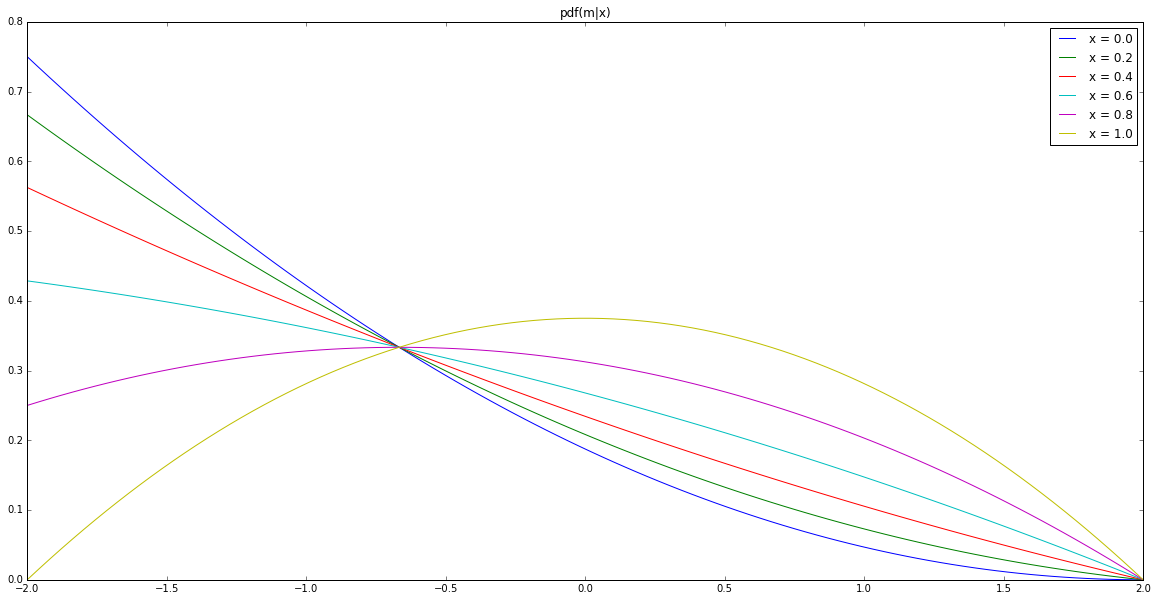

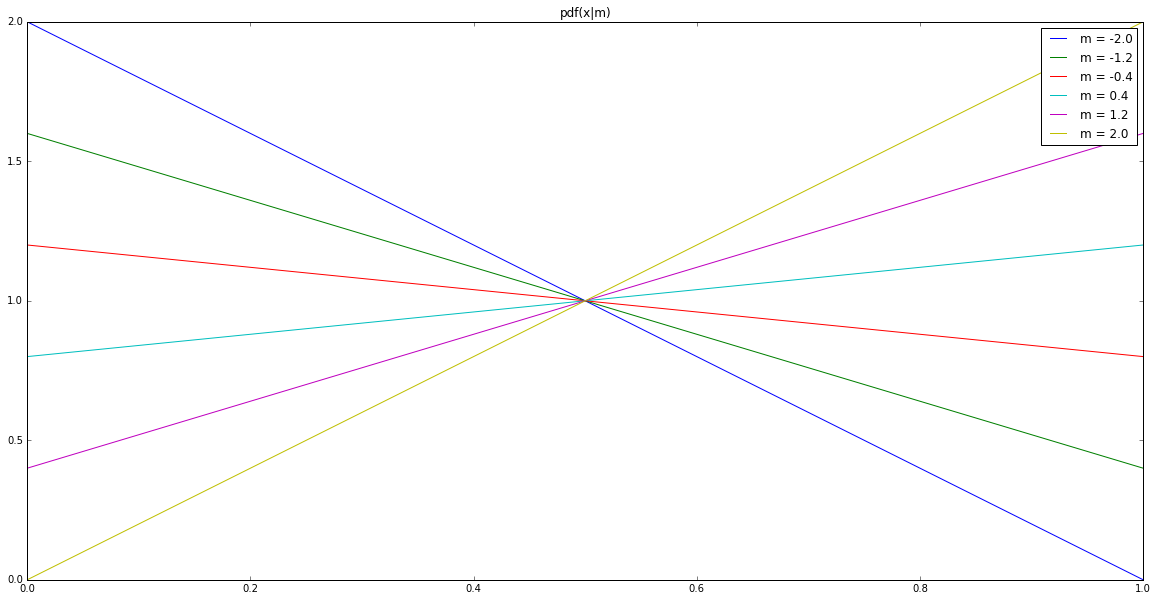

In [318]:
plot_pdf_m_x()
plot_pdf_x_m()

1.4 1.75757575758


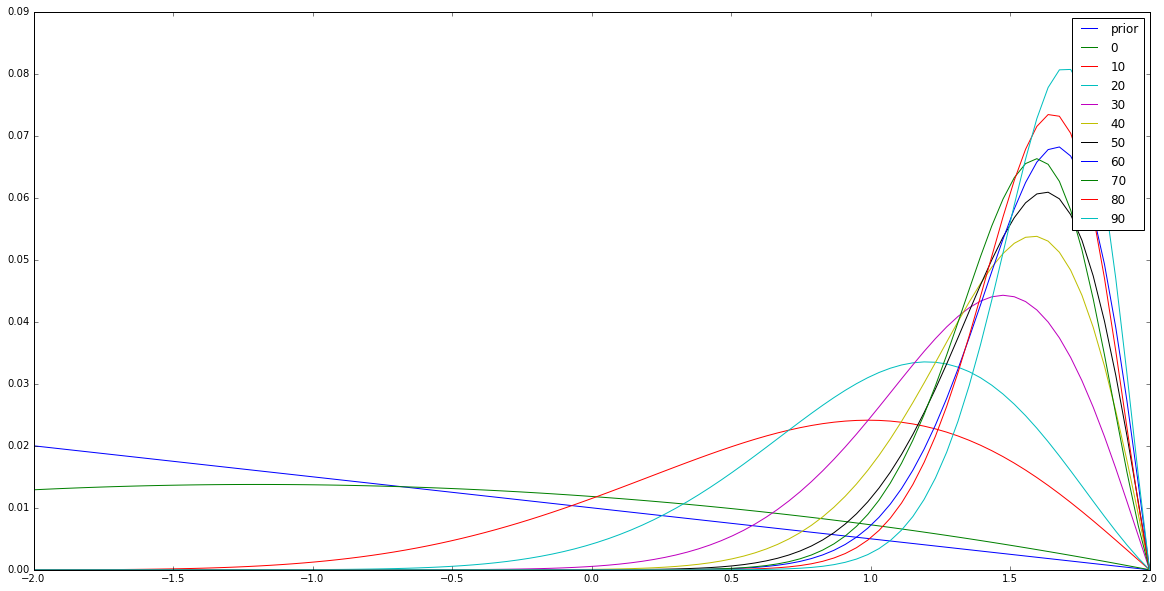

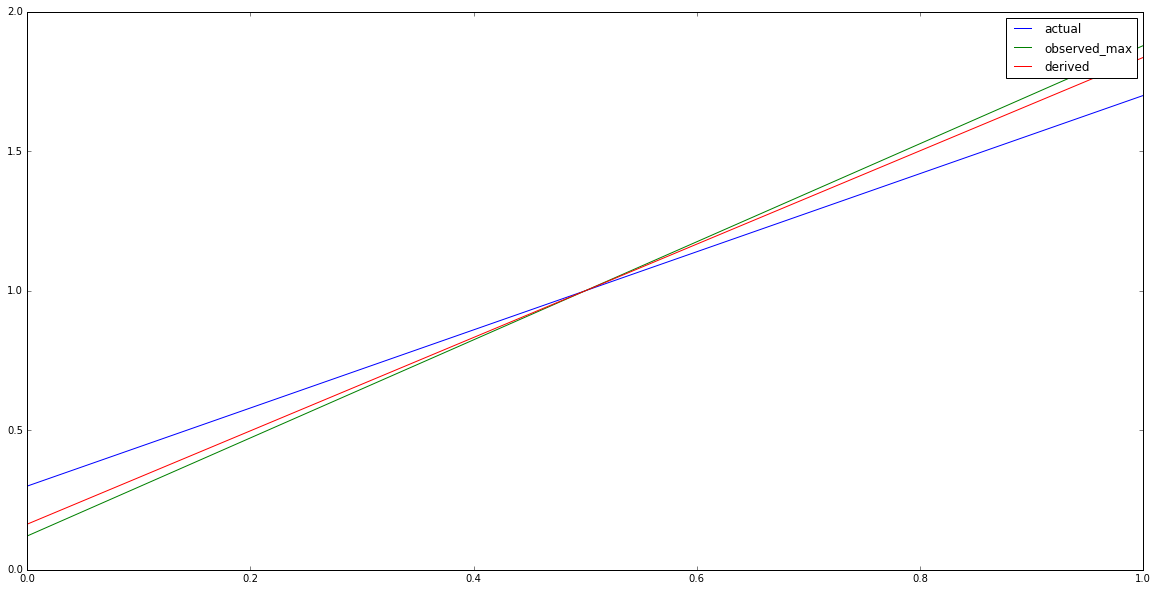

In [319]:
actual_m = 1.4

d = generate_x_data(actual_m)

# create and normalize prior - pdf(m)
prior = [pdf_m(i) for i in m]
#prior = [1.0 for i in m]


prior = [r/sum(prior) for r in prior]

plt.figure(figsize=(20,10))
plt.plot(m, prior, label='prior')

# iterate through trials, and plot once in a while
for idx, sample in enumerate(d[:100]):
    prior = update_prior(sample, prior)
    if idx % 10 == 0:
        plt.plot(m, prior, label=idx)

plt.legend()

observed_max_m = [m_val for m_val, a in zip(m, prior) if a == max(prior)][0]

# generate pdf(x) from our prior pdf(m)
fx = [0 for i in x]
for idx, x_s in enumerate(x):
    r = 0
    for m_s, p in zip(m, prior):
        r += pdf_x_m(x_s, m_s) * p
    
    fx[idx] = r
    

print actual_m, observed_max_m

plt.figure(figsize=(20,10))
plt.plot(x, [pdf_x_m(i, actual_m) for i in x], label='actual')
plt.plot(x, [pdf_x_m(i, observed_max_m) for i in x], label='observed_max')
plt.plot(x, fx, label='derived')
plt.legend()